In [1]:
from tqdm import tqdm
import numpy as np
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import BCEWithLogitsLoss
import torch.nn.functional as F
import segmentation_models_pytorch as smp

import model
import metrics
import config
import utis

import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, random_split
from dataset import HistoricalImagesDataset
import config
import glob

# Ignore excessive warnings
import logging
logging.propagate = False 
logging.getLogger().setLevel(logging.ERROR)

# WandB – Import the wandb library
import wandb

/share/etud/e2008984/miniconda3/envs/env_thesis/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Paths
IMAGES_PATH = '../data/patches/images/1942'
MASK_PATH = '../data/patches/masks/1942'
BEST_MODEL = '../best_model'
# PREDICTIONS_PATH = 

image_paths = glob.glob(IMAGES_PATH +'/*.tif')[:80]
mask_paths = glob.glob(MASK_PATH +'/*.tif')[:80]

### Weights and Biases

In [3]:
!wandb login

wandb: Currently logged in as: vibferreira (use `wandb login --relogin` to force relogin)


### Dataloader

In [4]:
# Dataset Object 
print('Number of image patches:', len(image_paths),'\nNumber of mask patches:', len(mask_paths))
dataset = HistoricalImagesDataset(image_paths, mask_paths)
data = next(iter(dataset))
print('shape image', data[0].shape, 'shape mask', data[1].shape)       

# Train, Test, Split -- DEVEOLP A SPLITTING STRATEGY BASED ON THE SPATIAL INFORMATION !!!!!!!!!
print('Splitting data into TRAIN, VAL and TEST')
train_size = int(0.5 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size]) #-- pytorch alternative to the train_test_split command line from Scikit-Learn

train_size = int(0.5 * len(train_dataset))
val_size = len(train_dataset) - train_size
test_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# DataLoader
print("Training set size: ", len(train_dataset))
train_dataloader = DataLoader(dataset=train_dataset, batch_size = config.BATCH_SIZE)
print("Validation set size: ", len(val_dataset))
val_dataloader = DataLoader(dataset=val_dataset, batch_size = config.BATCH_SIZE)
print("Testing set size: ", len(test_dataset))
test_dataloader = DataLoader(dataset=test_dataset, batch_size = config.BATCH_SIZE)

Number of image patches: 80 
Number of mask patches: 80
shape image torch.Size([1, 512, 512]) shape mask torch.Size([1, 512, 512])
Splitting data into TRAIN, VAL and TEST
Training set size:  40
Validation set size:  20
Testing set size:  20


### Check if CUDA is available

In [5]:
print(f'{config.DEVICE} is available')

cpu is available


### Training

In [6]:
def train(model, dataloader, optim, lossFunc, epoch):
    # set the model in training mode
    model.train()

    # Save total train loss
    totalTrainLoss = 0
    
    # metrics
    accuracy = 0
    iou = 0
    f1score = 0
    
    # loop over the training set
    loop = tqdm(dataloader, leave=False)
    for x, y in loop:
        # send the input to the device
        (x, y) = (x.to(config.DEVICE), y.float().to(config.DEVICE))
        
        # forward
        # with torch.cuda.amp.autocast(): # setting float16 to speed up the traiing
        pred = model(x)
        loss = lossFunc(pred, y)
        
        optim.zero_grad()  # zero out any previously accumulated gradients
        loss.backward() # obtain the gradients with respect to the loss
        opt.step() # perform one step of gradient descendent
        totalTrainLoss += loss  # add the loss to the total training loss so far 
        
        # metrics      
        all_metrics = metrics.metrics(pred, y)
        accuracy += all_metrics['acc']
        iou += all_metrics['iou']
        f1score += all_metrics['f1score']
        
        # update tqdm
        loop.set_description(f'Training Epoch [{epoch}/{config.NUM_EPOCHS}]')
        loop.set_postfix(loss=loss.item(), acc = all_metrics['acc'], iou=all_metrics['iou'])
        
    # calculate the average training loss PER EPOCH
    avgTrainLoss = totalTrainLoss / len(dataloader)
    avgAccLoss = accuracy / len(dataloader)
    avgIOU = iou / len(dataloader)
    avgF1score = f1score / len(dataloader)
    
    ## update training history
    training_history["avg_train_loss"].append(avgTrainLoss.cpu().detach().numpy()) # save the avg loss
    training_history["train_accuracy"].append(avgAccLoss) # save the acc 
    training_history["IoU"].append(avgIOU) # save the iou
    training_history["f1score"].append(avgF1score) # save the f1score
    
    # WANDB
    wandb.log({
    # "Examples": example_images,
    "Train Loss": avgTrainLoss,
    "Train Accuracy": avgAccLoss,
    "IoU_train":avgIOU})
    
    return training_history

In [7]:
def validation(model, dataloader, lossFunc, epoch):
    # Save total train loss
    totalValLoss = 0
    
    # metrics
    accuracy_val = 0
    iou_val = 0
    f1score_val = 0
    
    iter_ = 1
    # switch off autograd
    with torch.no_grad():
    # set the model in evaluation mode
        model.eval()
        # loop over the validation set
        loop = tqdm(dataloader, leave=False)
        for (x_val, y_val) in loop:
            # send the input to the device
            (x_val, y_val) = (x_val.to(config.DEVICE), y_val.to(config.DEVICE))
            
            # make the predictions and calculate the validation loss
            pred_val = model(x_val)
            loss = lossFunc(pred_val, y_val)
            totalValLoss += loss
            
            # metrics      
            all_metrics = metrics.metrics(pred_val, y_val)
            accuracy_val += all_metrics['acc']
            iou_val += all_metrics['iou']
            f1score_val += all_metrics['f1score']
            
            # Plotting Val 
            # if iter_  % 2 == 0: # plot every time iter is a multiple of 2
            utis.plot_comparison(pred_val, y_val)
            iter_ += 1 
            
            # update tqdm
            loop.set_description(f'Validation Epoch [{epoch}/{config.NUM_EPOCHS}]')
            loop.set_postfix(loss_val=loss.item(), acc_val = all_metrics['acc'], iou_val=all_metrics['iou'])

                        
    # calculate the average VALIDATION loss PER EPOCH
    avgValLoss = totalValLoss / len(dataloader)
    avgAccLoss = accuracy_val / len(dataloader)
    avgIOU = iou_val / len(dataloader)
    avgF1score = f1score_val / len(dataloader)

    ## update VALIDATION history
    validation_history["avg_val_loss"].append(avgValLoss.cpu().detach().numpy()) # save the avg loss
    validation_history["val_accuracy"].append(avgAccLoss) # save the acc
    validation_history["IoU_val"].append(avgIOU) # save the iou
    validation_history["f1score_val"].append(avgF1score) # save the iou
    
    # WANDB
    wandb.log({
    # "Examples": example_images,
    "Val Accuracy": avgAccLoss,
    "Val Loss": avgValLoss,
    "IoU_val": avgIOU})
    
    return validation_history

### MAIN

wandb: Currently logged in as: vibferreira (use `wandb login --relogin` to force relogin)


Training the network for 10 epochs, with a batch size of 5


  0%|          | 0/4 [00:00<?, ?it/s]                                                                              

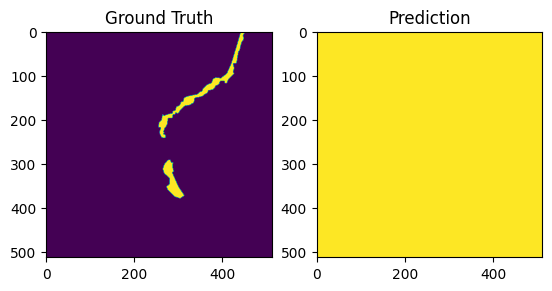

Validation Epoch [0/10]:  25%|██▌       | 1/4 [00:02<00:06,  2.22s/it, acc_val=0.00083884445, iou_val=0.00083884445, loss_val=0.998]

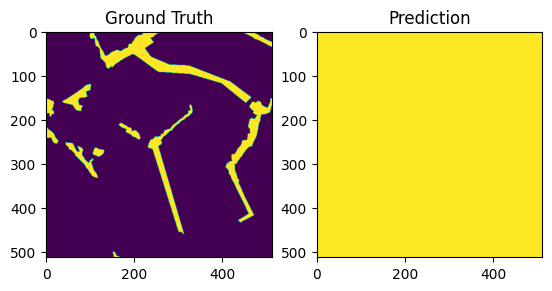

Validation Epoch [0/10]:  50%|█████     | 2/4 [00:04<00:04,  2.08s/it, acc_val=0.001227453, iou_val=0.001227453, loss_val=0.998]    

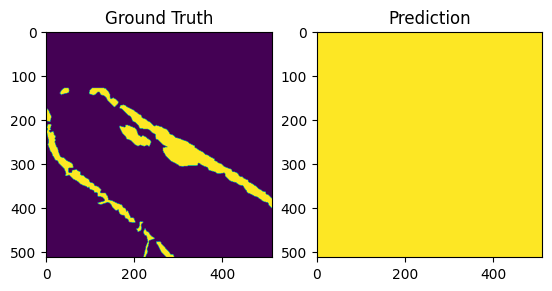

Validation Epoch [0/10]:  75%|███████▌  | 3/4 [00:06<00:02,  2.04s/it, acc_val=0.0006829445, iou_val=0.0006829445, loss_val=0.999]

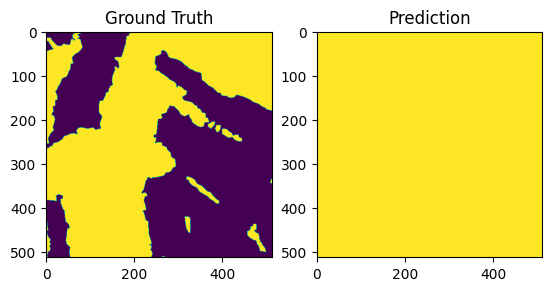

  0%|          | 0/4 [00:00<?, ?it/s]                                                                                             

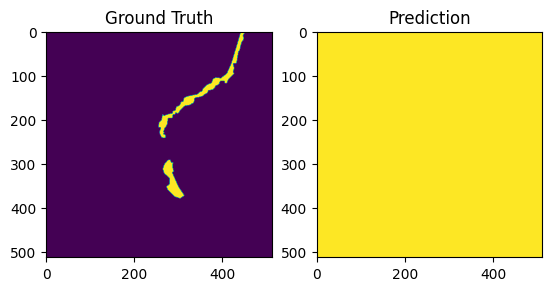

Validation Epoch [1/10]:  25%|██▌       | 1/4 [00:02<00:06,  2.26s/it, acc_val=0.00083884445, iou_val=0.00083884445, loss_val=0.998]

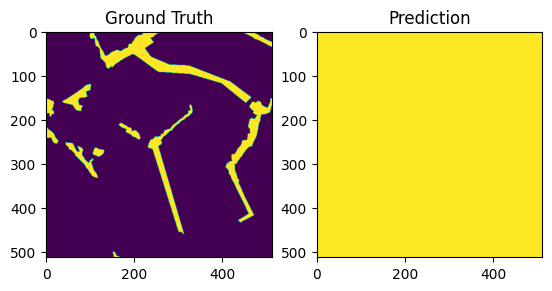

Validation Epoch [1/10]:  50%|█████     | 2/4 [00:04<00:04,  2.23s/it, acc_val=0.001227453, iou_val=0.001227453, loss_val=0.998]    

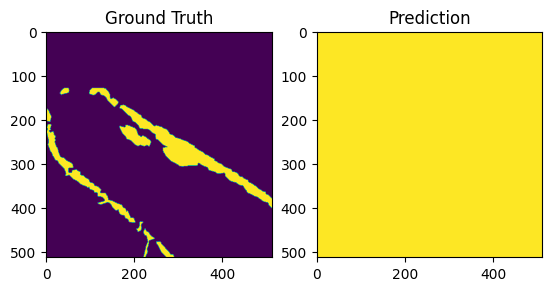

Validation Epoch [1/10]:  75%|███████▌  | 3/4 [00:06<00:02,  2.17s/it, acc_val=0.0006829445, iou_val=0.0006829445, loss_val=0.999]

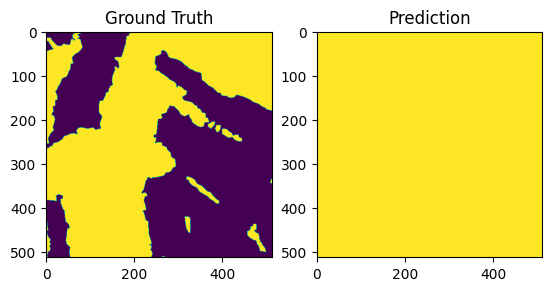

  0%|          | 0/4 [00:00<?, ?it/s]                                                                                             

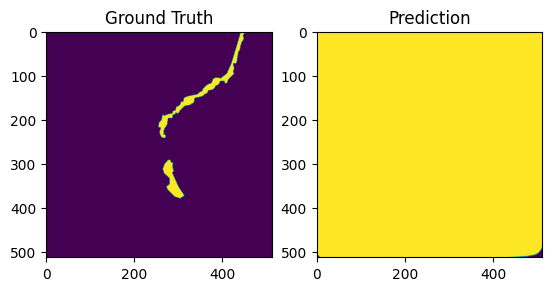

Validation Epoch [2/10]:  25%|██▌       | 1/4 [00:02<00:06,  2.23s/it, acc_val=0.001796088, iou_val=0.0008395254, loss_val=0.998]

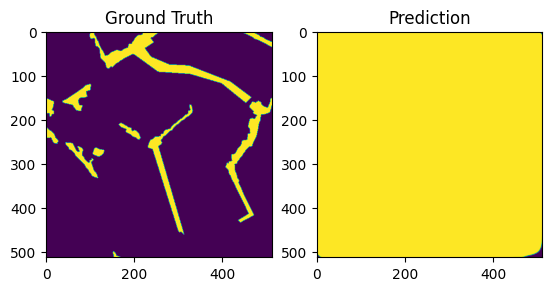

Validation Epoch [2/10]:  50%|█████     | 2/4 [00:04<00:04,  2.14s/it, acc_val=0.0026585, iou_val=0.0012290983, loss_val=0.998]  

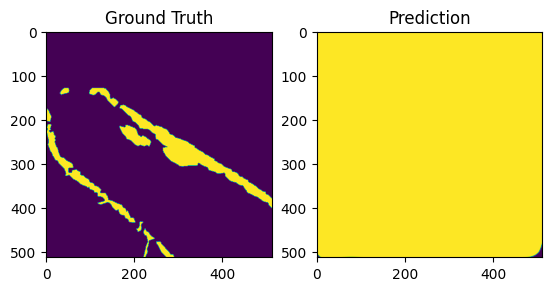

Validation Epoch [2/10]:  75%|███████▌  | 3/4 [00:06<00:02,  2.16s/it, acc_val=0.0017982181, iou_val=0.0006836351, loss_val=0.999]

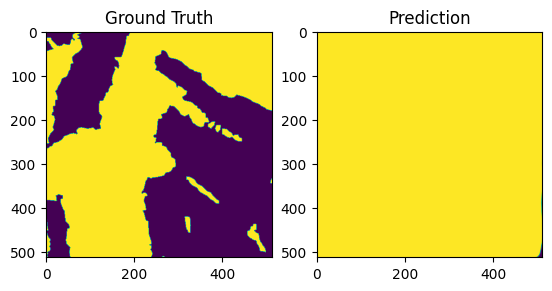

  0%|          | 0/4 [00:00<?, ?it/s]                                                                                             

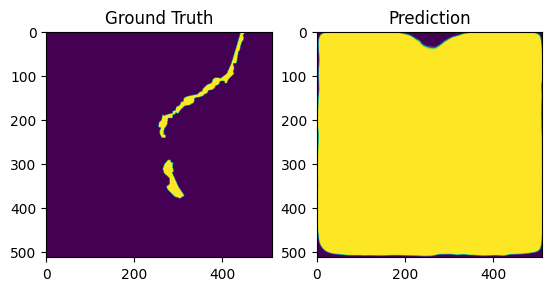

Validation Epoch [3/10]:  25%|██▌       | 1/4 [00:01<00:05,  1.99s/it, acc_val=0.030221567, iou_val=0.0008585527, loss_val=0.998]

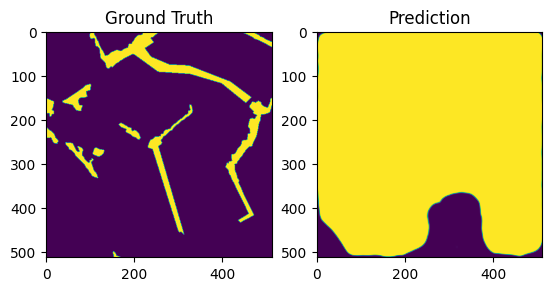

Validation Epoch [3/10]:  50%|█████     | 2/4 [00:04<00:04,  2.00s/it, acc_val=0.038120613, iou_val=0.0012683818, loss_val=0.997]

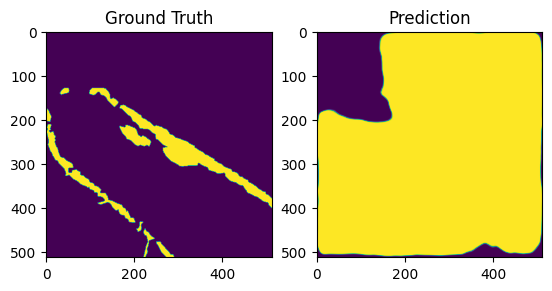

Validation Epoch [3/10]:  75%|███████▌  | 3/4 [00:05<00:01,  2.00s/it, acc_val=0.06520582, iou_val=0.0007216632, loss_val=0.999] 

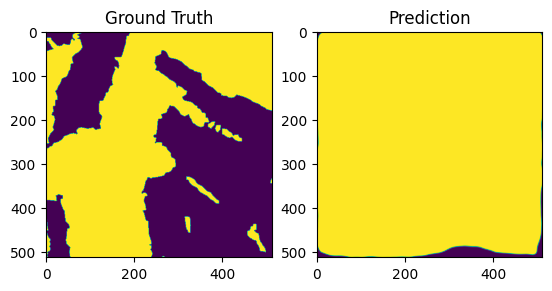

  0%|          | 0/4 [00:00<?, ?it/s]                                                                                           

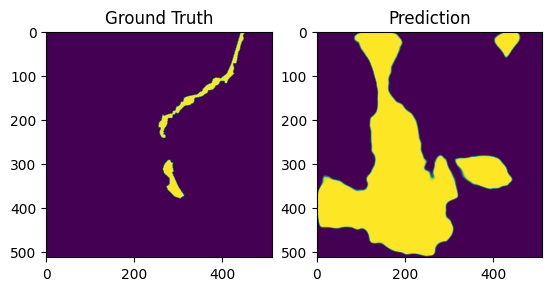

Validation Epoch [4/10]:  25%|██▌       | 1/4 [00:02<00:06,  2.24s/it, acc_val=0.37282646, iou_val=0.0012833041, loss_val=0.997]

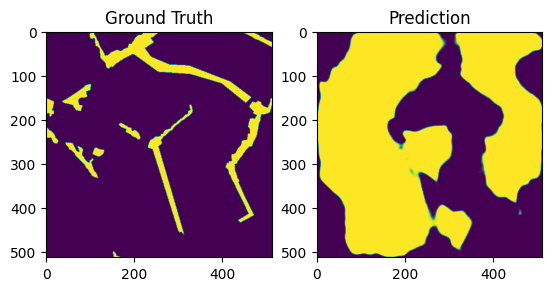

Validation Epoch [4/10]:  50%|█████     | 2/4 [00:04<00:04,  2.20s/it, acc_val=0.35417128, iou_val=0.001861987, loss_val=0.996] 

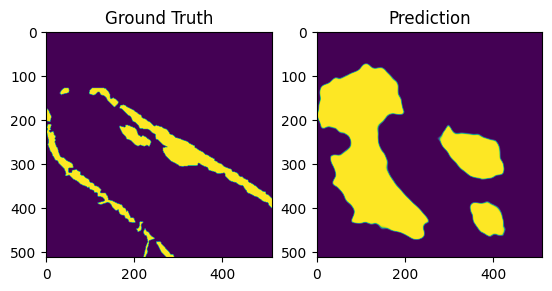

Validation Epoch [4/10]:  75%|███████▌  | 3/4 [00:06<00:02,  2.15s/it, acc_val=0.47306094, iou_val=0.0011870298, loss_val=0.998]

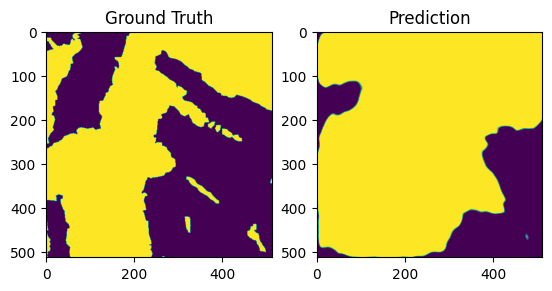

  0%|          | 0/4 [00:00<?, ?it/s]                                                                                           

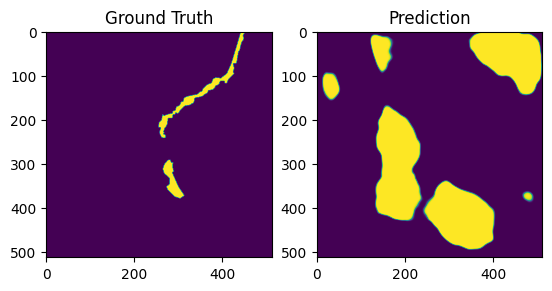

Validation Epoch [5/10]:  25%|██▌       | 1/4 [00:02<00:06,  2.31s/it, acc_val=0.48001093, iou_val=0.0014975313, loss_val=0.997]

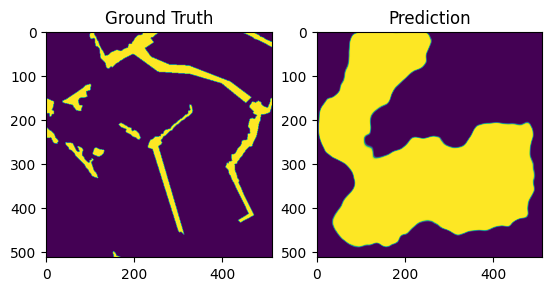

Validation Epoch [5/10]:  50%|█████     | 2/4 [00:04<00:04,  2.26s/it, acc_val=0.47772914, iou_val=0.0022104157, loss_val=0.996]

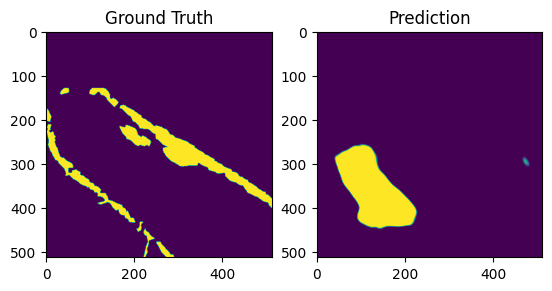

Validation Epoch [5/10]:  75%|███████▌  | 3/4 [00:06<00:02,  2.22s/it, acc_val=0.6841506, iou_val=0.0017361145, loss_val=0.997] 

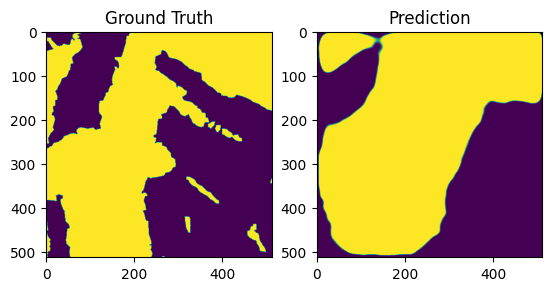

  0%|          | 0/4 [00:00<?, ?it/s]                                                                                           

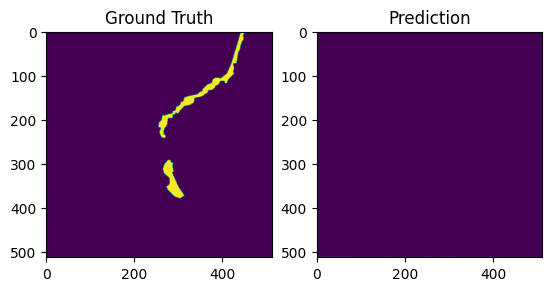

Validation Epoch [6/10]:  25%|██▌       | 1/4 [00:02<00:06,  2.19s/it, acc_val=0.71555245, iou_val=0.0024754943, loss_val=0.995]

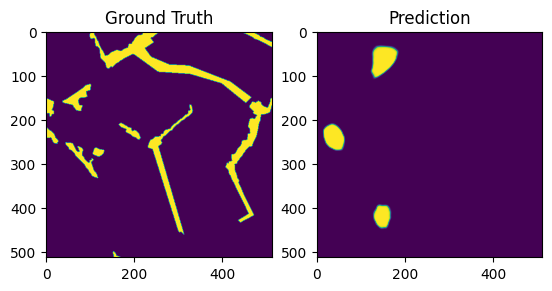

Validation Epoch [6/10]:  50%|█████     | 2/4 [00:04<00:04,  2.14s/it, acc_val=0.65827715, iou_val=0.0031457548, loss_val=0.994]

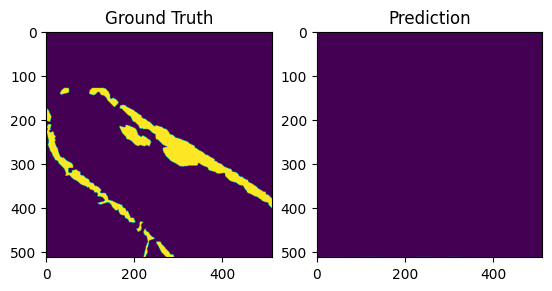

Validation Epoch [6/10]:  75%|███████▌  | 3/4 [00:06<00:02,  2.18s/it, acc_val=0.8130673, iou_val=0.0027876673, loss_val=0.994] 

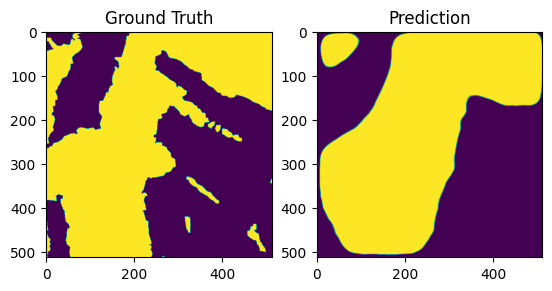

  0%|          | 0/4 [00:00<?, ?it/s]                                                                                          

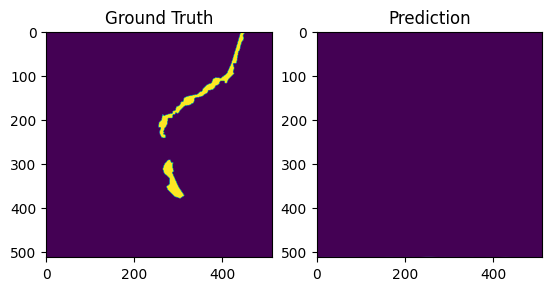

Validation Epoch [7/10]:  25%|██▌       | 1/4 [00:02<00:06,  2.17s/it, acc_val=0.774436, iou_val=0.003092605, loss_val=0.994]

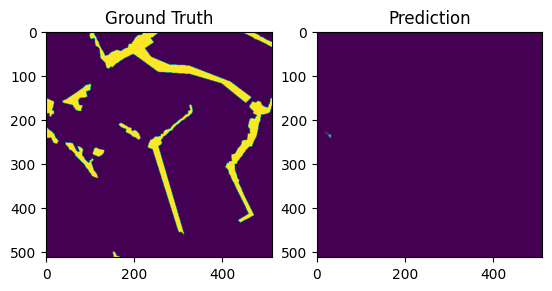

Validation Epoch [7/10]:  50%|█████     | 2/4 [00:04<00:04,  2.15s/it, acc_val=0.6732152, iou_val=0.0032503693, loss_val=0.994]

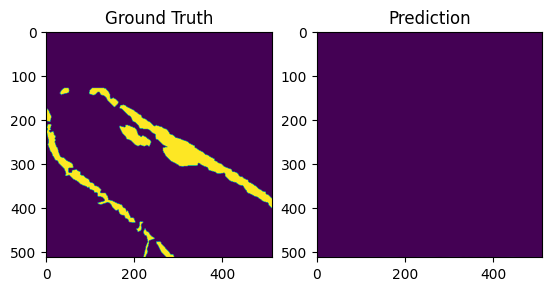

Validation Epoch [7/10]:  75%|███████▌  | 3/4 [00:06<00:02,  2.14s/it, acc_val=0.8324255, iou_val=0.0031268292, loss_val=0.994]

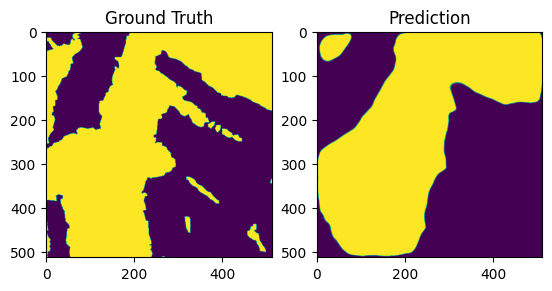

  0%|          | 0/4 [00:00<?, ?it/s]                                                                                          

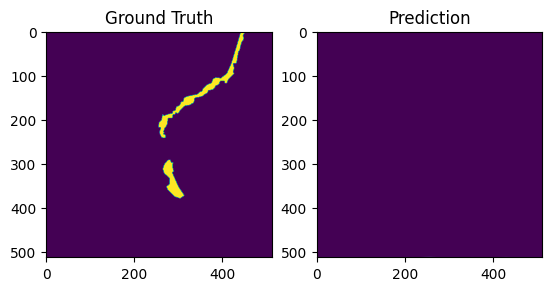

Validation Epoch [8/10]:  25%|██▌       | 1/4 [00:02<00:06,  2.17s/it, acc_val=0.8358496, iou_val=0.0037444544, loss_val=0.993]

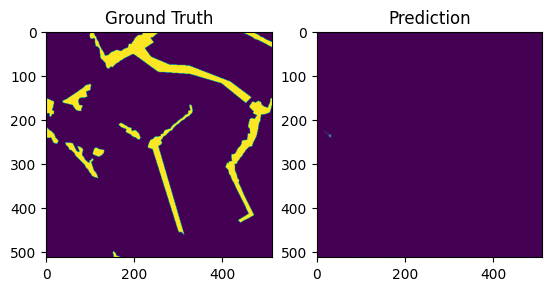

Validation Epoch [8/10]:  50%|█████     | 2/4 [00:04<00:04,  2.14s/it, acc_val=0.72373736, iou_val=0.0036046284, loss_val=0.993]

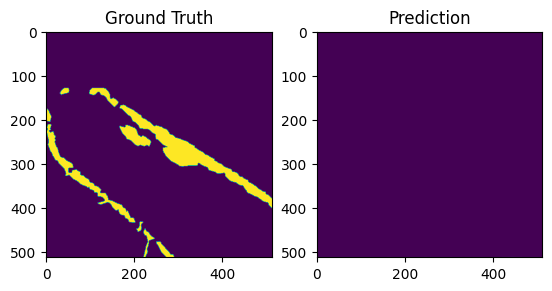

Validation Epoch [8/10]:  75%|███████▌  | 3/4 [00:06<00:02,  2.14s/it, acc_val=0.86539984, iou_val=0.0036426887, loss_val=0.993]

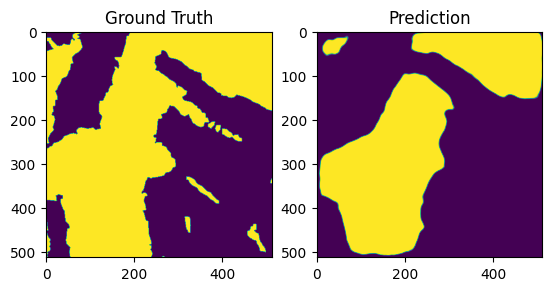

  0%|          | 0/4 [00:00<?, ?it/s]                                                                                           

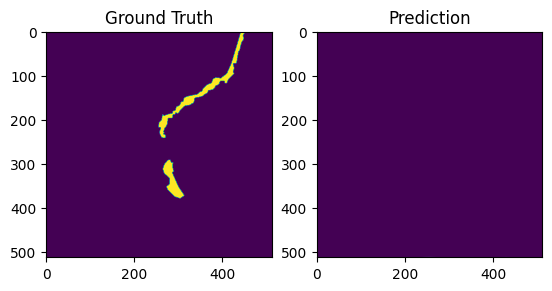

Validation Epoch [9/10]:  25%|██▌       | 1/4 [00:02<00:06,  2.15s/it, acc_val=0.87289906, iou_val=0.003880028, loss_val=0.992]

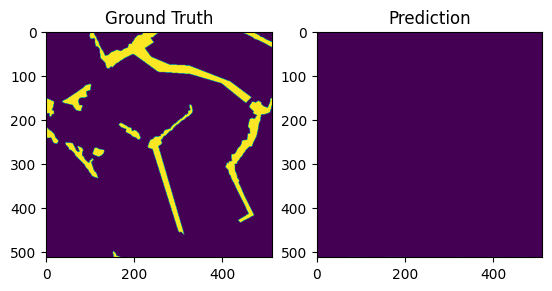

Validation Epoch [9/10]:  50%|█████     | 2/4 [00:04<00:04,  2.13s/it, acc_val=0.776853, iou_val=0.003788592, loss_val=0.992]  

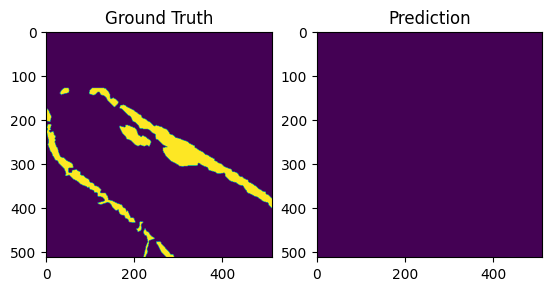

Validation Epoch [9/10]:  75%|███████▌  | 3/4 [00:06<00:02,  2.13s/it, acc_val=0.8915044, iou_val=0.0038312108, loss_val=0.992]

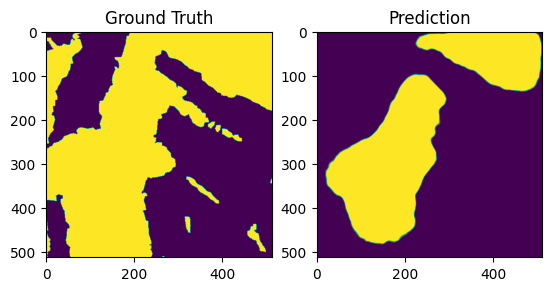

In [8]:
# WandB – Initialize a new run
wandb.init(entity="vibferreira", project="master_thesis")
wandb.watch_called = False # Re-run the model without restarting the runtime, unnecessary after our next release

# Initialize our model
unet = model.unet_model.to(config.DEVICE)

# initialize loss function and optimizer
lossFunc = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
opt = optim.Adam(unet.parameters(), lr=config.LR)

# initialize a dictionary to store TRAINING history (keep track on training)
training_history = {"avg_train_loss": [], "train_accuracy": [], "IoU":[],"f1score":[]}

# # initialize a dictionary to store VALIDATION history (keep track on VALIDATION)
validation_history = {"avg_val_loss": [], "val_accuracy": [], "IoU_val":[], "f1score_val":[]}

# Using log="all" log histograms of parameter values in addition to gradients
wandb.watch(unet, log="all")

# initialize best accuracy
best_accuracy = 0.0
print(f'''Training the network for {config.NUM_EPOCHS} epochs, with a batch size of {config.BATCH_SIZE}''') # try with logger

# loop = tqdm(range(config.NUM_EPOCHS))
for e in range(config.NUM_EPOCHS):
    trained = train(unet, train_dataloader, opt, lossFunc, epoch=e)
    validated = validation(unet, val_dataloader, lossFunc, epoch=e)
    
    # Save best model
    if validated['val_accuracy'][-1] > best_accuracy : # maybe add a minimum number of epochs as conditions
        utis.save_best_model(unet, BEST_MODEL, validated, e)
        best_accuracy = validation_history['val_accuracy'][-1]

In [9]:
trained

{'avg_train_loss': [array(0.9968975, dtype=float32),
  array(0.9935837, dtype=float32),
  array(0.99289453, dtype=float32),
  array(0.99271065, dtype=float32),
  array(0.992468, dtype=float32),
  array(0.992483, dtype=float32),
  array(0.99254936, dtype=float32),
  array(0.99241686, dtype=float32),
  array(0.99241203, dtype=float32),
  array(0.9923744, dtype=float32)],
 'train_accuracy': [0.6494842916727066,
  0.8187072649598122,
  0.9199021458625793,
  0.9484090134501457,
  0.9631960690021515,
  0.9531709924340248,
  0.9657082110643387,
  0.9604543074965477,
  0.9424640089273453,
  0.9445458725094795],
 'IoU': [0.0017053340998245403,
  0.0033419853425584733,
  0.003588511928683147,
  0.003661315655335784,
  0.003783645195653662,
  0.0037743516149930656,
  0.003740274900337681,
  0.0038068782014306635,
  0.003809103218372911,
  0.0038279861328192055],
 'f1score': [tensor(0.0034),
  tensor(0.0067),
  tensor(0.0072),
  tensor(0.0073),
  tensor(0.0075),
  tensor(0.0075),
  tensor(0.0075),

### Predictions

In [10]:
def save_predictions_as_imgs():
    pass

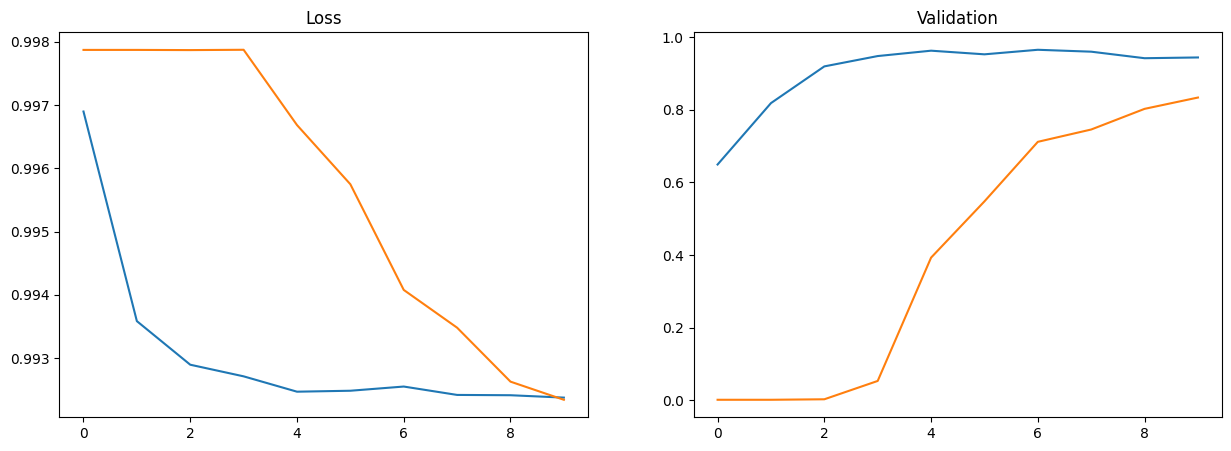

In [11]:
_, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].plot(training_history['avg_train_loss'], label= 'train')
ax[0].plot(validation_history['avg_val_loss'], label='val')
ax[0].set_title('Loss')
ax[1].plot(training_history['train_accuracy'], label= 'train')
ax[1].plot(validation_history['val_accuracy'], label='val')
ax[1].set_title('Validation')
plt.show()